In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [4]:
pop = pd.read_csv('https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/asrh/sc-est2019-agesex-civ.csv')
pop = pop[pop.SEX == 0]
pop = pop[['NAME','AGE','POPEST2019_CIV']]
pop.columns = ['NAME','AGE','Population']
pop['AgeGroup'] = pd.cut(pop['AGE'], bins = [-1, 24, 34, 44, 54, 64, 74, 84, 85, 9999],
       labels = ['0-24','25-34','35-44','45-54','55-64','65-74','75-84','85+','All Ages'])
population = pop.groupby(['NAME','AgeGroup'])['Population'].sum().reset_index()

In [5]:
Biggest = population[population.AgeGroup == 'All Ages'].sort_values('Population', ascending = False)['NAME']
def get_biggest_states(number = 10):
    number = number + 1
    return Biggest[:number]

In [6]:
center = pd.read_csv("https://www2.census.gov/geo/docs/reference/cenpop2010/CenPop2010_Mean_ST.txt")
also = pd.read_csv("https://www2.census.gov/geo/docs/reference/cenpop2010/CenPop2010_Mean_US.txt")
also['STNAME'] = 'United States'
center = center.append(also)
center = center[['STNAME','LATITUDE','LONGITUDE']]

In [7]:
df = pd.read_csv('Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age.csv')

In [8]:
def condition_to_group(condition):
    condition = condition.replace(['Influenza and pneumonia','Chronic lower respiratory diseases','Adult respiratory distress syndrome',
                       'Respiratory failure','Respiratory arrest','Other diseases of the respiratory system'],'Respiratory diseases')
    condition = condition.replace(['Hypertensive diseases','Ischemic heart disease','Cardiac arrest','Cardiac arrhythmia',
                                  'Heart failure','Cerebrovascular diseases','Other diseases of the circulatory system'],'Circulatory diseases')
    return condition
def condition_to_ICD10(condition):
    codes = ['J09-J18','J40-J47','J80','J96','R09.2','J00-J06, J20-J39, J60-J70, J81-J86, J90-J95, J97-J99, U04',
            'I10-I15','I20-I25','I46','I44, I45, I47-I49','I50','I60-I69',
            'I00-I09, I26-I43, I51, I52, I70-I99','A40-A41','C00-C97','E10-E14','E65-E68','G30',
             'F01, F03','N17-N19',
             'S00-T98, V01-X59, X60-X84, X85-Y09, Y10-Y36, Y40-Y89, U01-U03',
             'A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F00, F02, F04-G26, G31-H95, K00-K93, L00-M99, N00-N16, N20-N98, O00-O99, P00-P96, Q00-Q99, R00-R08, R09.0, R09.1, R09.3, R09.8, R10-R99',
            'U071']
    conditions = ['Influenza and pneumonia','Chronic lower respiratory diseases',
                  'Adult respiratory distress syndrome','Respiratory failure','Respiratory arrest',
                'Other diseases of the respiratory system','Hypertensive diseases','Ischemic heart disease',
                'Cardiac arrest','Cardiac arrhythmia','Heart failure','Cerebrovascular diseases',
                'Other diseases of the circulatory system','Sepsis','Malignant neoplasms','Diabetes',
                  'Obesity','Alzheimer disease','Vascular and unspecified dementia',
                  'Renal failure',
                  'Intentional and unintentional injury, poisoning, and other adverse events',
                  'All other conditions and causes (residual)','COVID-19']
    condition = condition.replace(conditions, codes)
    return condition

In [9]:
df = df[(df.State != 'Puerto Rico') & (df.State != 'New York City')]
filt = df[(df['Start Date'] != '05/01/2021') & (df['Group'] == 'By Month')]
by_may1 = filt.groupby(['State','Age Group','Condition'])[['COVID-19 Deaths','Number of Mentions']].sum().reset_index()                                                
by_may1['Condition Group'] = condition_to_group(by_may1['Condition'])
by_may1 = by_may1.merge(population, how='left', left_on=['State','Age Group'], right_on=['NAME','AgeGroup'])
by_may1 = by_may1.drop(['NAME','AgeGroup'], axis = 1)
by_may1['Death Rate'] = by_may1['COVID-19 Deaths']/by_may1['Population']*100
by_may1['Mention Rate'] = by_may1['Number of Mentions']/by_may1['Population']*100

In [10]:
df = df.merge(population, how = 'left', left_on=['State','Age Group'], right_on = ['NAME','AgeGroup'])
df = df.drop(['NAME','AgeGroup'], axis = 1)
df['Death Rate'] = df['COVID-19 Deaths']/df['Population']*100
df['Mention Rate'] = df['Number of Mentions']/df['Population']*100
df = df[(df['Start Date'] != '05/01/2021')]
df = df.drop(['Flag','Data As Of','Start Date','End Date','ICD10_codes'], axis = 1)

### Clustering

In [53]:
df['Group'].unique()

array(['By Total', 'By Year', 'By Month'], dtype=object)

In [54]:
df_by_month = df.query('Group == "By Month"')

In [55]:
df_by_month.head()

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Number of Mentions,Population,Death Rate,Mention Rate
35880,By Month,2020.0,1.0,United States,Respiratory diseases,Influenza and pneumonia,0-24,0.0,0.0,102821051.0,0.000000,0.000000
35881,By Month,2020.0,2.0,United States,Respiratory diseases,Influenza and pneumonia,0-24,0.0,0.0,102821051.0,0.000000,0.000000
35882,By Month,2020.0,3.0,United States,Respiratory diseases,Influenza and pneumonia,0-24,9.0,9.0,102821051.0,0.000009,0.000009
35883,By Month,2020.0,4.0,United States,Respiratory diseases,Influenza and pneumonia,0-24,27.0,30.0,102821051.0,0.000026,0.000029
35884,By Month,2020.0,5.0,United States,Respiratory diseases,Influenza and pneumonia,0-24,20.0,20.0,102821051.0,0.000019,0.000019


In [56]:
df_by_month['Month'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [57]:
def segment_by_season(df, start_month, end_month):
    mask = df['Month'].between(start_month, end_month)
    df = df[mask]
    return df

In [58]:
df_spring = segment_by_season(df_by_month, 3.0 , 5.0)
df_summer = segment_by_season(df_by_month, 6.0 , 8.0)
df_fall = segment_by_season(df_by_month, 9.0 , 11.0)
df_winter = segment_by_season(df_by_month, 12.0, 2.0)

In [64]:
df_spring_cl = df_spring[['State', 'Condition Group', 'Condition','Age Group', 'COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate']]
df_summer_cl = df_summer[['State', 'Condition Group', 'Condition','Age Group', 'COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate']]
df_fall_cl = df_fall[['State', 'Condition Group','Condition', 'Age Group', 'COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate']]
df_winter_cl = df_winter[['State', 'Condition Group', 'Condition','Age Group', 'COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate']]


#### Categorical Data Encoding

In [61]:
df_spring_cl.head()

,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Population,Death Rate,Mention Rate
35882,United States,Respiratory diseases,Influenza and pneumonia,0-24,9.0,102821051.0,0.000009,0.000009
35883,United States,Respiratory diseases,Influenza and pneumonia,0-24,27.0,102821051.0,0.000026,0.000029
35884,United States,Respiratory diseases,Influenza and pneumonia,0-24,20.0,102821051.0,0.000019,0.000019
35894,United States,Respiratory diseases,Influenza and pneumonia,0-24,24.0,102821051.0,0.000023,0.000025
35895,United States,Respiratory diseases,Influenza and pneumonia,0-24,23.0,102821051.0,0.000022,0.000024


##### Target Encoding
- state is related with Population and covid-19 deaths
- Condition Group is related with covid-19 deaths
- Condition is related wit covid-19 deaths
- we can use covid-19 deaths as target variable to conduct target encoding

In [65]:
from category_encoders import TargetEncoder
def encode_categorical(to_encode_column_name, target_name, new_col_name, df):
    encoder = TargetEncoder()
    df[new_col_name] = encoder.fit_transform(df[to_encode_column_name], df[target_name])

In [66]:
encode_categorical("State", "COVID-19 Deaths", 'State_encoded', df_spring_cl)
encode_categorical("Condition Group", "COVID-19 Deaths", 'Cond_encoded', df_spring_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCop

In [67]:
encode_categorical("State", "COVID-19 Deaths", "State_encoded", df_summer_cl)
encode_categorical("Condition Group", "COVID-19 Deaths", "Cond_encoded",df_summer_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCop

In [68]:
encode_categorical("State", "COVID-19 Deaths", "State_encoded", df_fall_cl)
encode_categorical("Condition Group", "COVID-19 Deaths", "Cond_encoded", df_fall_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCop

In [69]:
encode_categorical("State", "COVID-19 Deaths", "State_encoded", df_winter_cl)
encode_categorical("Condition Group", "COVID-19 Deaths", "Cond_encoded", df_winter_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [70]:
#target encode condition
encode_categorical("Condition", "COVID-19 Deaths", 'Con_encoded', df_spring_cl)
encode_categorical("Condition", "COVID-19 Deaths", 'Con_encoded', df_summer_cl)
encode_categorical("Condition", "COVID-19 Deaths", 'Con_encoded', df_fall_cl)
encode_categorical("Condition", "COVID-19 Deaths", 'Con_encoded', df_winter_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCop

##### Label Encoding
- Label Encoding on Age Group 

In [71]:
from sklearn import preprocessing
def label_encoding(df):
    le = preprocessing.LabelEncoder()
    df['Age_labeled'] = le.fit_transform(df[['Age Group']])

In [72]:
label_encoding(df_spring_cl)
label_encoding(df_summer_cl)
label_encoding(df_fall_cl)
label_encoding(df_winter_cl)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [73]:
df_spring_cl.head()

,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Population,Death Rate,Mention Rate,State_encoded,Cond_encoded,Con_encoded,Age_labeled
35882,United States,Respiratory diseases,Influenza and pneumonia,0-24,9.0,102821051.0,0.000009,0.000009,946.961739,54.14612,132.357849,0
35883,United States,Respiratory diseases,Influenza and pneumonia,0-24,27.0,102821051.0,0.000026,0.000029,946.961739,54.14612,132.357849,0
35884,United States,Respiratory diseases,Influenza and pneumonia,0-24,20.0,102821051.0,0.000019,0.000019,946.961739,54.14612,132.357849,0
35894,United States,Respiratory diseases,Influenza and pneumonia,0-24,24.0,102821051.0,0.000023,0.000025,946.961739,54.14612,132.357849,0
35895,United States,Respiratory diseases,Influenza and pneumonia,0-24,23.0,102821051.0,0.000022,0.000024,946.961739,54.14612,132.357849,0


In [84]:
df_spring_som = df_spring_cl[['COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate', 'State_encoded', 'Cond_encoded', 'Con_encoded', 'Age_labeled']]
df_summer_som = df_summer_cl[['COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate', 'State_encoded', 'Cond_encoded', 'Con_encoded', 'Age_labeled']]
df_fall_som = df_fall_cl[['COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate', 'State_encoded', 'Cond_encoded', 'Con_encoded', 'Age_labeled']]
df_winter_som = df_winter_cl[['COVID-19 Deaths', 'Population', 'Death Rate', 'Mention Rate', 'State_encoded', 'Cond_encoded', 'Con_encoded', 'Age_labeled']]

In [123]:
def drop_na(df):
    df.dropna(inplace=True)

In [124]:
drop_na(df_spring_som)
drop_na(df_summer_som)
drop_na(df_fall_som)

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [127]:
print(df_spring_som.shape)
print(df_summer_som.shape)
print(df_fall_som.shape)
print(df_winter_som.shape)

(35582, 8)
(21125, 8)
(21455, 8)
(0, 8)


In [128]:
data_spring = df_spring_som[df_spring_som.columns].values
data_summer = df_summer_som[df_summer_som.columns].values
data_fall = df_fall_som[df_fall_som.columns].values
# data_winter = df_winter_som[df_winter_som.columns].values

##### Normalization

In [129]:
from sklearn import preprocessing
def normalize(data, df): 
    df_new = df.copy()
    scaler = preprocessing.MinMaxScaler()
    df_new[df.columns] = scaler.fit_transform(data)
    return df_new

In [130]:
df_spring_nom = normalize(data_spring, df_spring_som)
df_summer_nom = normalize(data_summer, df_summer_som)
df_fall_nom = normalize(data_fall, df_fall_som)
# winter data is empty, not include winter data in analysis

In [131]:
nom_sp_data = df_spring_nom.values
nom_su_data = df_summer_nom.values
nom_fa_data = df_fall_nom.values
nom_win_data = df_winter.values

### SOM

In [95]:
from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

In [100]:
# check the number of unique death conditions
def check_unique_conditions(df):
    targets = df['Condition'].values
    print(df['Condition'].nunique())
    n = df['Condition'].nunique()
    return targets, n

In [101]:
targets_sp, n_sp = check_unique_conditions(df_spring_cl)
targets_su, n_su = check_unique_conditions(df_summer_cl)
targets_fa, n_fa = check_unique_conditions(df_fall_cl)

23
23
23


In [102]:
# generate markers and colors for conditions
from matplotlib.lines import Line2D
# generate number of markers as the counts of unique death conditions
markers_all = []
for key in Line2D.markers.keys():
    markers_all.append(key)
markers = markers_all[:23]

from itertools import cycle
cycol = cycle('bgrcmk')
colors = []
for i in range(23):
    colors.append(next(cycol))


In [104]:
# generate markers for death conditions
def generate_label_markers(targets, markers):
    markers_som = []
    rec_set = set()
    i = -1
    for lab in targets: 
        if lab not in rec_set: 
            rec_set.add(lab)
            i += 1
        markers_som.append(markers[i])
    # print(len(markers_som))
    return markers_som

In [108]:
# generate legend elements containing death conditions
def generate_legend_elements(markers, colors, labels):
    legend_elements = []
    for i in range(len(labels)): 
        hexagon = Line2D([0], [0], marker=markers[i], color=colors[i], label=labels[i],
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)
        legend_elements.append(hexagon)
    return legend_elements

In [109]:
markers_som = generate_label_markers(targets_sp, markers)
colors_som = generate_label_markers(targets_sp, colors)

In [110]:
from minisom import MiniSom
def train_som(data):
    som = MiniSom(15, 15, data.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

    som.train(data, 100, verbose=True)
    return som 

In [111]:
def hexagon_visualize(som, data, markers, colors, targets):
    xx, yy = som.get_euclidean_coordinates()
    umatrix = som.distance_map()
    weights = som.get_weights()
    
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hex = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cm.Blues(umatrix[i, j]), 
                                 alpha=.4, 
                                 edgecolor='gray')
            ax.add_patch(hex)


    for cnt, x in enumerate(data):
        # getting the winner
        w = som.winner(x)
        # place a marker on the winning position for the sample xx
        wx, wy = som.convert_map_to_euclidean(w) 
        wy = wy * np.sqrt(3) / 2
        plt.plot(wx, wy, 
                 markers_som[cnt], 
                 markerfacecolor='None',
                 markeredgecolor=colors_som[cnt], 
                 markersize=12, 
                 markeredgewidth=2)

    xrange = np.arange(weights.shape[0])
    yrange = np.arange(weights.shape[1])
    plt.xticks(xrange-.5, xrange)
    plt.yticks(yrange * np.sqrt(3) / 2, yrange)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                      rotation=270, fontsize=16)
    plt.gcf().add_axes(ax_cb)

    legend_elements = generate_legend_elements(markers, colors, list(set(targets)))
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
              borderaxespad=0., ncol=3, fontsize=14)

    # plt.savefig('/Users/cookiepoon/STA160_projects/som_death_conditions.png')
    plt.show()


 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: nan


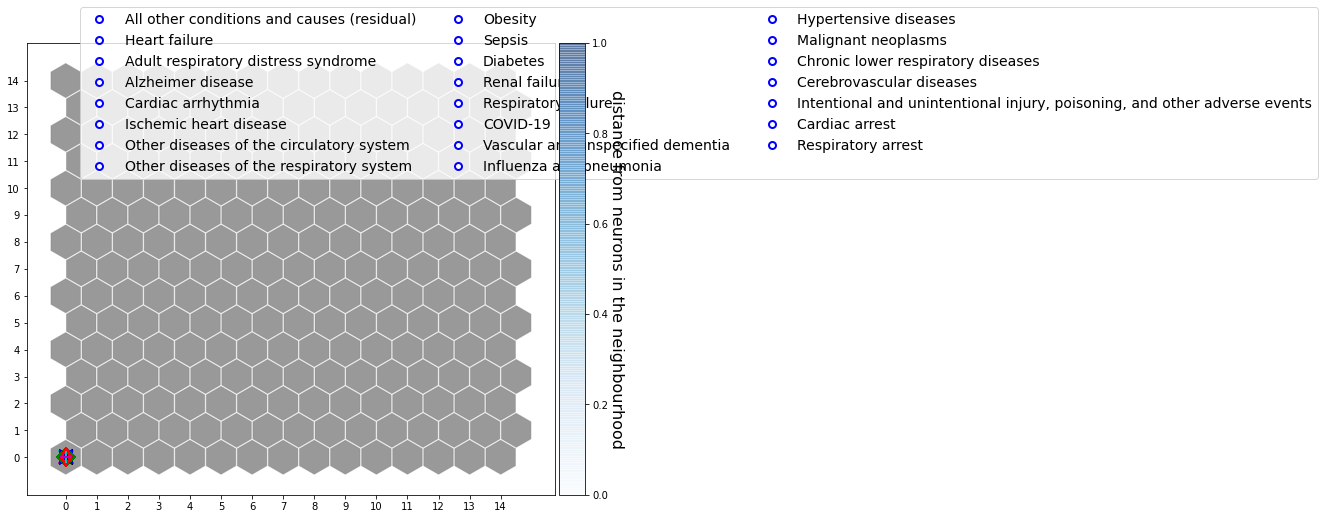

In [118]:
som_spring = train_som(data_spring)
hexagon_visualize(som_spring, nom_sp_data, markers_som, colors_som, targets_sp)

### Clustering

In [119]:
from sklearn.cluster import KMeans

In [120]:
def elbow_method(data_cl):
    # determine the number of clusters
    #The Elbow method looks at how the total WSS(within cluster sum of squares) varies with the number of clusters.
    wcss = []
    for i in range(1,16):
        km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
        km.fit(data_cl)
        wcss.append(km.inertia_)
    plt.plot(range(1,16),wcss, c="#c51b7d")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.title('Elbow Method', size=15)
    plt.xlabel('Number of clusters', size=15)
    plt.ylabel('wcss', size=15)
    plt.show() 

In [121]:
def train_KMeans(num_clusters, data_cl):
    # number of clusters
    km = KMeans(n_clusters=num_clusters)
    km.fit(data_cl)

    labels = km.predict(data_cl)
    #print(clusters)
    plt.scatter(data_cl[:, 0], data_cl[:, 1], c=labels,
            s=50, cmap='viridis')
    return km, labels

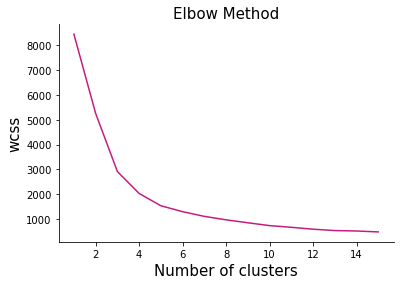

In [132]:
elbow_method(nom_sp_data)

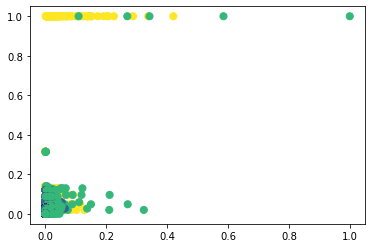

In [133]:
km_sp, labels_sp = train_KMeans(4, nom_sp_data)

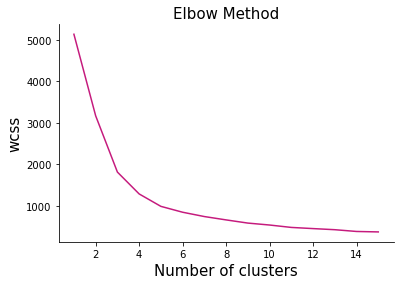

In [135]:
elbow_method(nom_su_data)

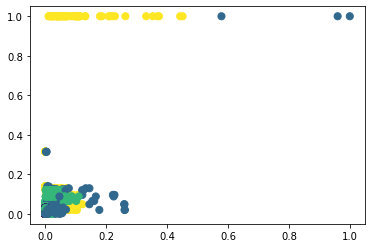

In [136]:
km_su, labels_su = train_KMeans(4, nom_su_data)

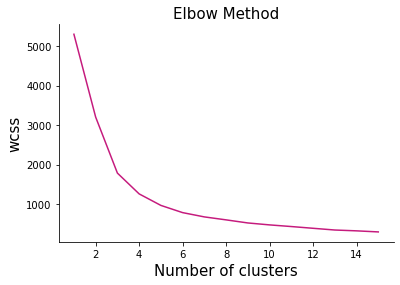

In [137]:
elbow_method(nom_fa_data)

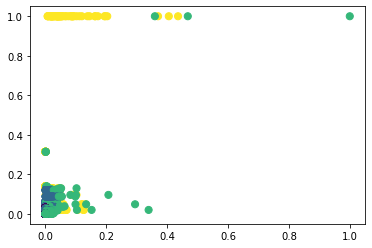

In [138]:
km_fa, labels_fa = train_KMeans(4, nom_fa_data)

### Analyze data based on cluster

In [139]:
# get centroids and corresponding index in the original dataset 
def group_data_clusters(data, centroids):
    cluster_dict = {}
    for i in range(len(centroids)):
        lab = centroids[i]
        if lab not in cluster_dict: 
            cluster_dict[lab] = []
        tmp = cluster_dict[lab]
        tmp.append(data[i])
        cluster_dict[lab] = tmp 
    return cluster_dict

In [154]:
df_spring_cl.head()

,State,Condition Group,Condition,Age Group,COVID-19 Deaths,Population,Death Rate,Mention Rate,State_encoded,Cond_encoded,Con_encoded,Age_labeled
35882,United States,Respiratory diseases,Influenza and pneumonia,0-24,9.0,102821051.0,0.000009,0.000009,946.961739,54.14612,132.357849,0
35883,United States,Respiratory diseases,Influenza and pneumonia,0-24,27.0,102821051.0,0.000026,0.000029,946.961739,54.14612,132.357849,0
35884,United States,Respiratory diseases,Influenza and pneumonia,0-24,20.0,102821051.0,0.000019,0.000019,946.961739,54.14612,132.357849,0
35894,United States,Respiratory diseases,Influenza and pneumonia,0-24,24.0,102821051.0,0.000023,0.000025,946.961739,54.14612,132.357849,0
35895,United States,Respiratory diseases,Influenza and pneumonia,0-24,23.0,102821051.0,0.000022,0.000024,946.961739,54.14612,132.357849,0


In [160]:
data_sp_tmp = df_spring_cl[['State', 'Condition Group', 'Condition', 'Age Group']].values
data_su_tmp = df_summer_cl[['State', 'Condition Group', 'Condition', 'Age Group']].values
data_fa_tmp = df_fall_cl[['State', 'Condition Group','Condition',  'Age Group']].values
data_win_tmp = df_winter_cl[['State', 'Condition Group', 'Condition', 'Age Group']].values

In [161]:
cluster_dict_sp = group_data_clusters(data_sp_tmp , labels_sp)
cluster_dict_su = group_data_clusters(data_sp_tmp , labels_su)
cluster_dict_fa = group_data_clusters(data_sp_tmp , labels_fa)


In [162]:
def array_to_list(cluster_dict, i):
    cluster_data = [l.tolist() for l in cluster_dict[i]]
    return cluster_data

In [163]:
def get_different_clusters_data(cluster_dict,num_lst):
    cluster_lst_dict = {}
    for num in num_lst: 
        data_cl = array_to_list(cluster_dict, num)
        cluster_lst_dict[num] = data_cl
    return cluster_lst_dict


In [164]:
sp_clusters_dict = get_different_clusters_data(cluster_dict_sp,[0, 1, 2, 3])
su_clusters_dict = get_different_clusters_data(cluster_dict_su,[0, 1, 2, 3])
fa_clusters_dict = get_different_clusters_data(cluster_dict_fa,[0, 1, 2, 3])

#### Spring Data Clusters

In [165]:
cl_col_names = ['State', 'Condition Group', 'Condition', 'Age Group']

In [166]:
df_sp_cl1 = pd.DataFrame(sp_clusters_dict[0], columns = cl_col_names)
df_sp_cl2 = pd.DataFrame(sp_clusters_dict[1], columns = cl_col_names)
df_sp_cl3 = pd.DataFrame(sp_clusters_dict[2], columns = cl_col_names)
df_sp_cl4 = pd.DataFrame(sp_clusters_dict[3], columns = cl_col_names)

##### (Spring)

In [187]:
def plot_top_death_conditions(df, top_n):
    f = sns.catplot(x="Condition", kind="count", palette="ch:.25", data=df[['Condition']], order = df.Condition.value_counts()[:top_n].index)
    f.set_xticklabels(rotation=40)

In [192]:
def plot_all_clusters_death_conditions(df_lst, top_n):
    # fig, ax = plt.subplots(2,2, figsize=(12,10))
    plot_top_death_conditions(df_lst[0], top_n)
    plot_top_death_conditions(df_lst[1], top_n)
    plot_top_death_conditions(df_lst[2], top_n)
    plot_top_death_conditions(df_lst[3], top_n)

    

In [199]:
def plot_top_age_groups(df, top_n):
    f1 = sns.catplot(x="Age Group", kind="count", palette="ch:.25", data=df[['Age Group']], order = df['Age Group'].value_counts()[:top_n].index)
    f1.set_xticklabels(rotation=40)

In [201]:
def plot_all_clusters_age_group(df_lst, top_n):
    # fig, ax = plt.subplots(2,2, figsize=(12,10))
    plot_top_age_groups(df_lst[0], top_n)
    plot_top_age_groups(df_lst[1], top_n)
    plot_top_age_groups(df_lst[2], top_n)
    plot_top_age_groups(df_lst[3], top_n)

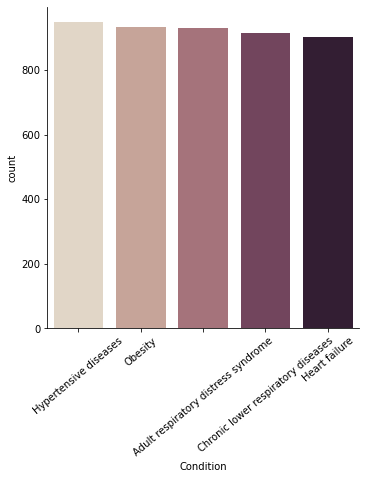

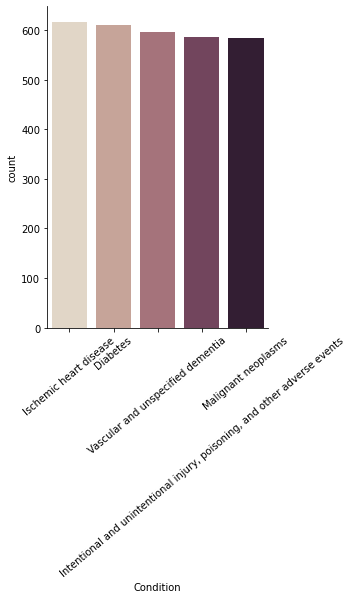

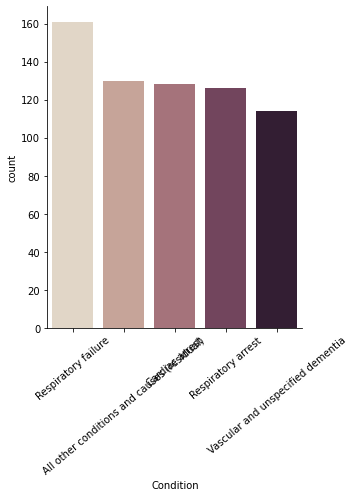

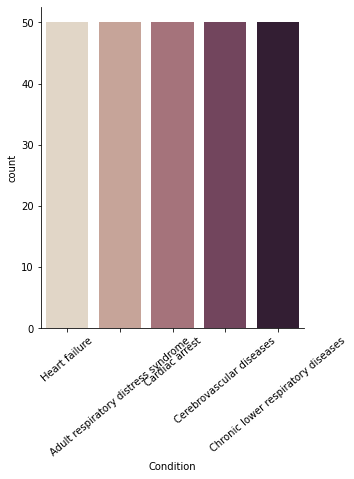

In [193]:
plot_all_clusters_death_conditions([df_sp_cl1, df_sp_cl2, df_sp_cl3, df_sp_cl4], 5)

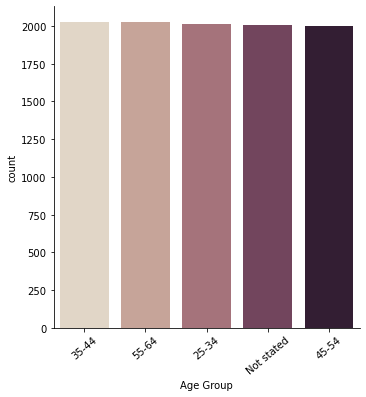

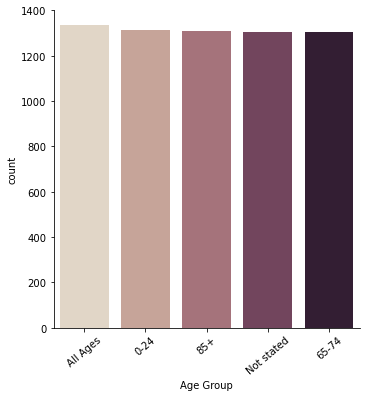

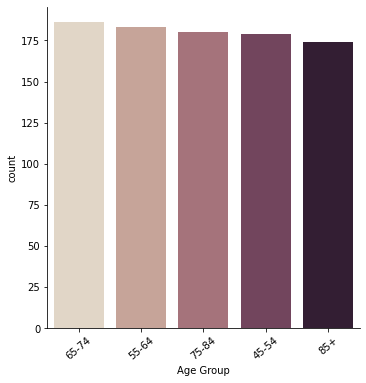

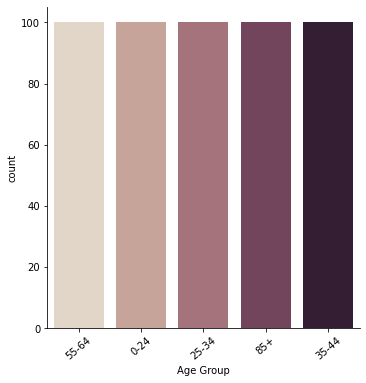

In [202]:
plot_all_clusters_age_group([df_sp_cl1, df_sp_cl2, df_sp_cl3, df_sp_cl4], 5)

In spring cluster, 
- the 1st cluster has a blend of respiratory death conditions and heart diseases (most common age group: 35-44, 55-54 )
- the 2nd cluster has mainly vascular diseases, and other injury death conditions (most common age group: All ages, 0-24, 85+ )
- the 3rd cluster has a blend of respiratory and vascular death conditions  (most common age group: All ages, 65-74, 55-64 )
- the 4th cluster has a blend of respiratory and heart failure. (most common age group: All ages, 55-64, 0-24)
- even though respiratory death, vascular death, and heart failure has across all ages, but the most common age group that are sensitive to respiratory and vascular death are around 65-74, 55-64

#### Summer data clusters

In [195]:
df_su_cl1 = pd.DataFrame(su_clusters_dict[0], columns = cl_col_names)
df_su_cl2 = pd.DataFrame(su_clusters_dict[1], columns = cl_col_names)
df_su_cl3 = pd.DataFrame(su_clusters_dict[2], columns = cl_col_names)
df_su_cl4 = pd.DataFrame(su_clusters_dict[3], columns = cl_col_names)

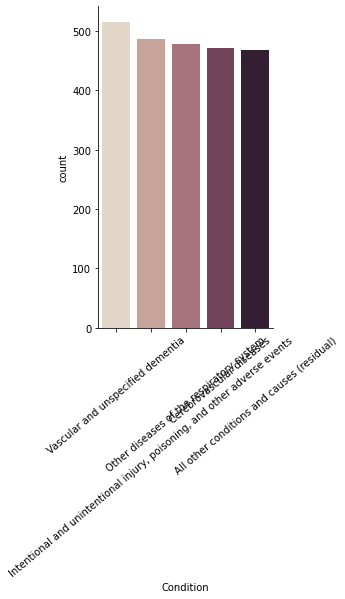

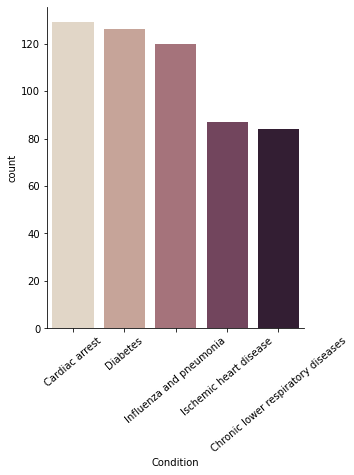

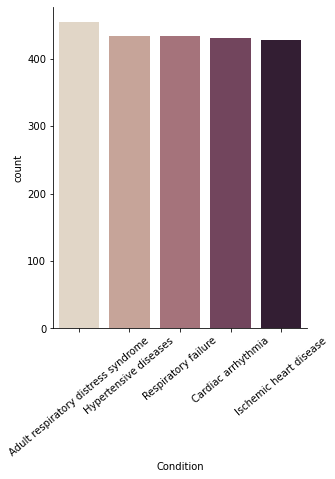

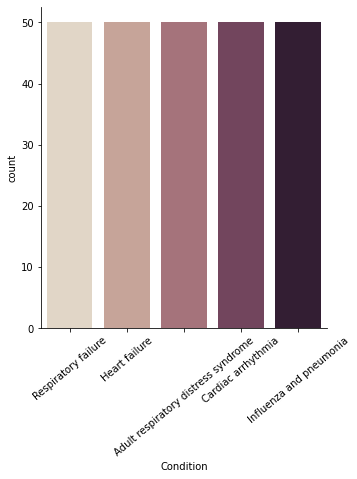

In [196]:
plot_all_clusters_death_conditions([df_su_cl1, df_su_cl2, df_su_cl3, df_su_cl4], 5)

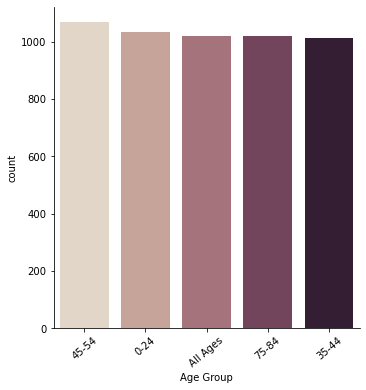

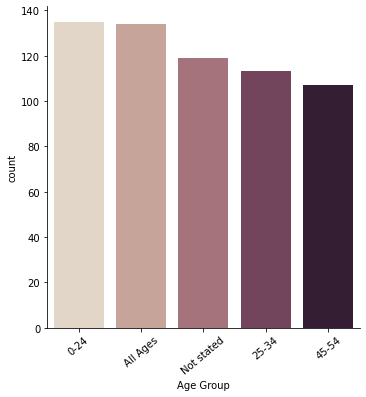

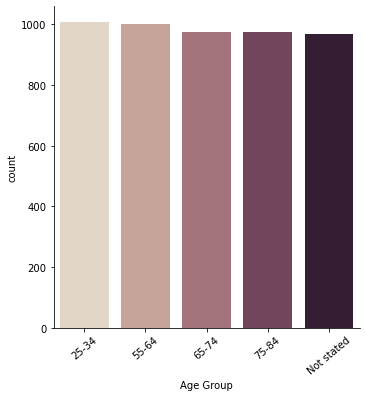

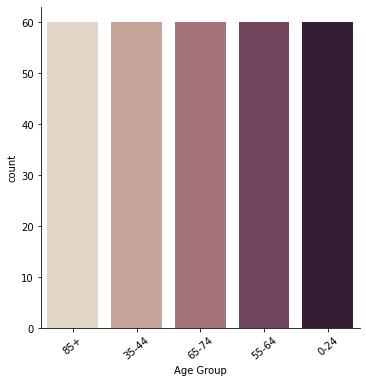

In [203]:
plot_all_clusters_age_group([df_su_cl1, df_su_cl2, df_su_cl3, df_su_cl4], 5)

In summer cluster, 
- the 1st cluster has a blend of vascular and other types of death conditions (45-54, 0-24)
- the 2nd cluster has mainly heart disease, respiratory, influenza (0-24, all ages)
- the 3rd cluster has a blend of respiratory and heart death conditions (25-34, 55-64)
- the 4th cluster has a blend of respiratory and heart failure, influenza. (85+, 35-44)
- the summer cluster shows a different pattern than spring cluster that it contains more younger age range such as 25-34, 35-44.

#### Fall Data Clusters

In [197]:
df_fa_cl1 = pd.DataFrame(fa_clusters_dict[0], columns = cl_col_names)
df_fa_cl2 = pd.DataFrame(fa_clusters_dict[1], columns = cl_col_names)
df_fa_cl3 = pd.DataFrame(fa_clusters_dict[2], columns = cl_col_names)
df_fa_cl4 = pd.DataFrame(fa_clusters_dict[3], columns = cl_col_names)

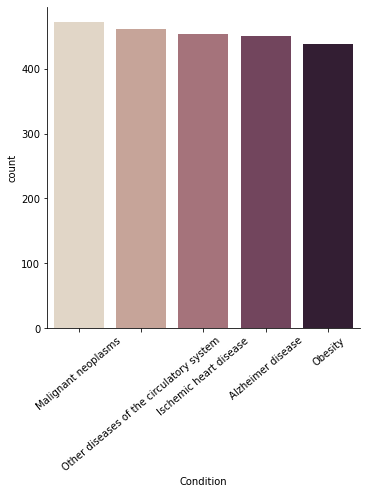

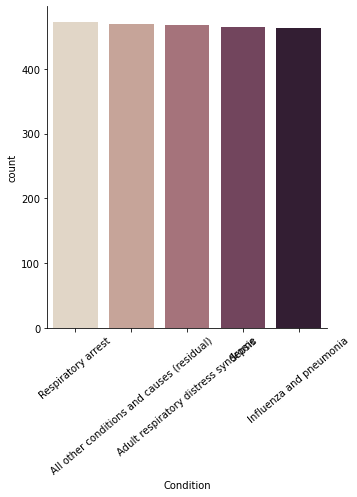

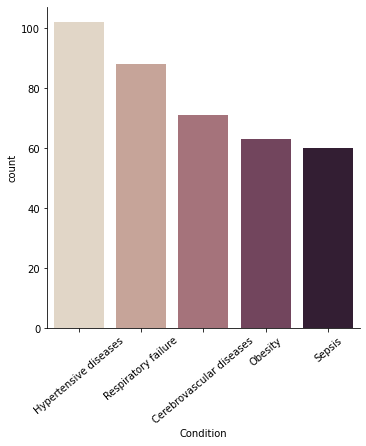

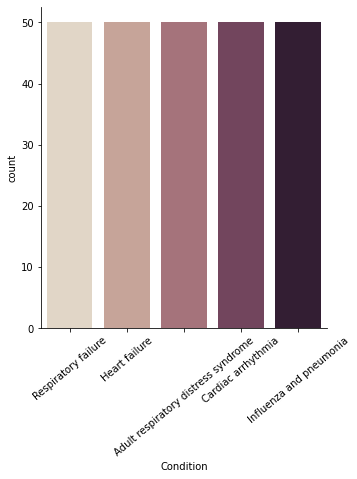

In [198]:
plot_all_clusters_death_conditions([df_fa_cl1, df_fa_cl2, df_fa_cl3, df_fa_cl4], 5)

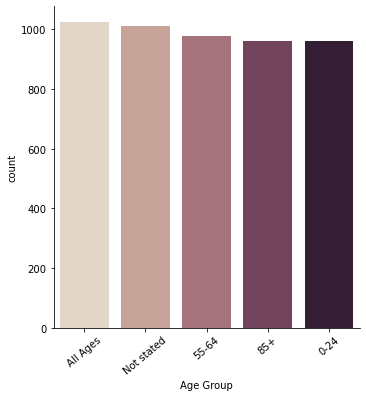

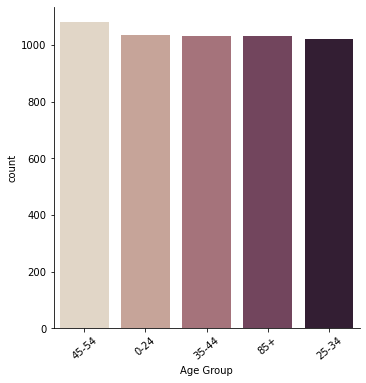

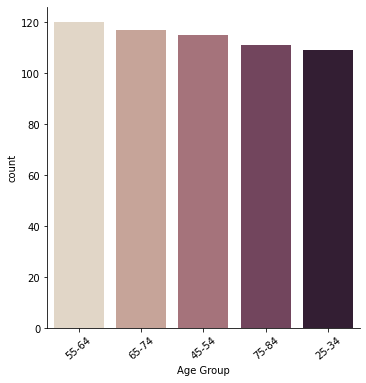

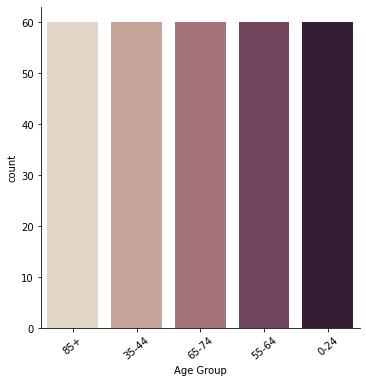

In [204]:
plot_all_clusters_age_group([df_fa_cl1, df_fa_cl2, df_fa_cl3, df_fa_cl4], 5)

In fall cluster, 
- the 1st cluster has a blend of vascular and heart death conditions (all ages, 55-64)
- the 2nd cluster has mainly respiratory, influenza (45-54, 0-24)
- the 3rd cluster has a blend of respiratory and vascular death conditions (55-64, 65-74)
- the 4th cluster has a blend of respiratory and heart failure, influenza. (85+, 35-44)
- The fall cluster is more concentrated on older age group, which is pretty simialr to spring cluster, excpet that fall cluster has influenza as the top death conditions,which was common during age 55-64, and 65-74. while spring cluster has respiratory and vascular death the most common for age 55-64, and 65-74.

In conclusion: 
- across spring, summer and fall, the main death conditions were respiratory and heart failure. 
- It's interesting that the spring cluster doesn't regard influenza as the top 5 death conditions among all clusters, but the summer and fall cluster has included influenza among the top 5 clusters. 
- Summer cluster has more younger age group while spring and fall cluster has more older age group
- Older age group as 55-64, and 65-74 were more common in respiratory and vascular death during spring while they were more common in influenza death. 